# NLP Tinder Play Store Reviews

## Introduction

Dating apps like Tinder have exploded in popularity over the past decade. However, not everyone has had a positive experience using them. Going through the review section on the Google play store can give us some insight on what it does well and what it lacks given the rating from a user. However, there are hundreds of thousands of reviews in the Google play store and one can't physically go through and analyze all of them. This is where deep learning becomes useful! Through deep learning, we can train models from given data to predict the sentiment of future reviews. This sentiment analysis can be useful to see if any changes to Tinder or any other app is bringing value to its users. 

The order of this notebook will be shown as:
1. Describing the Tinder reviews dataset
2. Doing Exploratory Data Analysis(EDA) on the Tinder dataset
3. Describing and Running the LSTM models
4. Describing and Running the GRU models
5. Analyzing Results from the LSTM and GRU model
6. Conclusion

First, we'll import some of the import some of the common libraries we need such as numpy, pandas and tensorflow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

## Dataset and the Problem

Let's import the Tinder review dataset. The dataset can be found on Kaggle here:

https://www.kaggle.com/datasets/shivkumarganesh/tinder-google-play-store-review

As seen below, there are a total of 440,387 reveiws. The content column contains the review. The score is the user rating of Tinder where 1 is the lowest and 5 is the highest. Our goal is to train deep learning models to be able to predict if a future review is a positive reveiw or a negative review.

In [2]:
tinder = pd.read_csv('tinder_google_play_reviews.csv')

In [3]:
tinder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440387 entries, 0 to 440386
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              440387 non-null  object
 1   userName              440383 non-null  object
 2   userImage             440387 non-null  object
 3   content               440351 non-null  object
 4   score                 440387 non-null  int64 
 5   thumbsUpCount         440387 non-null  int64 
 6   reviewCreatedVersion  336727 non-null  object
 7   at                    440387 non-null  object
 8   replyContent          25372 non-null   object
 9   repliedAt             25372 non-null   object
dtypes: int64(2), object(8)
memory usage: 33.6+ MB


## Exploratory Data Analysis

### Initial Look

First, we will remove any of the columns that we do not need. Now lets take a closer look at the dataset. We see that most of the ratings given are either a 1 or a 5 with fewer ratings in between. 

In [4]:
tinder = tinder.drop(columns = ['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion',
                                'at', 'replyContent', 'repliedAt'])
tinder.head()

,content,score
0,Not very inclusive. This app for one forces yo...,2
1,"Unfortunately, at this point, the only people ...",1
2,👍,5
3,app hides you and forces you to spend money to...,1
4,"Watch out, they will SHADOWBAN you FOR NO REAS...",1


In [5]:
tinder['score'].value_counts()

1    185478
5    153363
4     42468
3     30145
2     28932
0         1
Name: score, dtype: int64

<AxesSubplot: xlabel='score', ylabel='Count'>

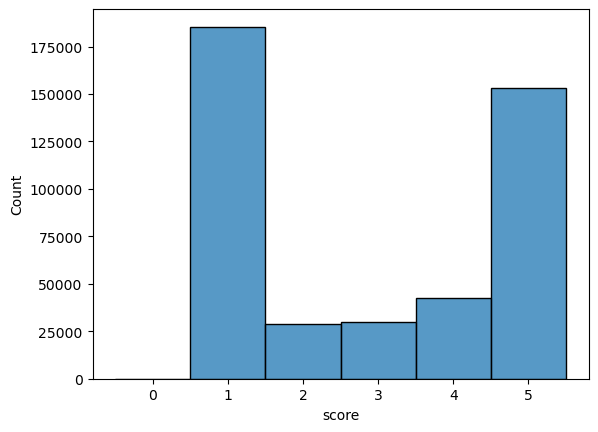

In [6]:
sns.histplot(data = tinder, x = tinder['score'], discrete = True)

Curiously, there is one review that somehow has a rating of 0. Since it is only a single entry, we will remove that entry.

In [7]:
tinder[tinder['score'] == 0]

,content,score
324374,Love it but ...my match is not replying its a ...,0


In [8]:
tinder = tinder[tinder['score'] != 0]

Since the ratings are in a bimodal distribution, we will combine the lower ratings together and the higher ratings together. Having such an uneven spread of ratings can cause in increase in bias for the most common of ratings. All ratings from 1-3 will be considered negative sentiment and ratings of 4 or 5 will be considered positive sentiment. Combined, that makes 244,555 negative reviews or 56% of the total reviews and 195,831 positive reviews or 44% of the total reviews.

In [9]:
tinder['sentiment'] = np.where(tinder['score'] > 3, 1,0)
tinder['sentiment'].value_counts()

0    244555
1    195831
Name: sentiment, dtype: int64

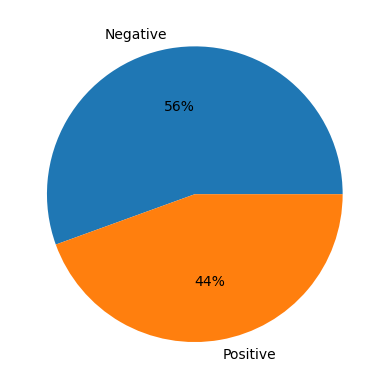

In [10]:
plt.pie(tinder['sentiment'].value_counts(), labels = ['Negative', 'Positive'], autopct='%.0f%%')
plt.show()

### Cleaning Data

We have now seen some of the preliminary data. Let's start to clean that data into something we can use. Below, we have a method that cleans the text data into something that we can use. For this process, we will be using the nltk library.
The process goes:

1. Make sure the reveiw is all lowercase
2. Remove all punctuation
3. Tokenize the text
4. Remove any numbers in the review
5. Remove any stop words in the review
6. Remove any non-ASCII characters
7. Lemmatize any verbs still present to reduce the number of similar words i.e. fish, fishing, fished

In [11]:
import string, re, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def remove_non_ascii(words):
    #Remove non-ASCII characters from list of tokenized words
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def lemmatize_verbs(words):
    #Lemmatize verbs in list of tokenized words
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def clean_data(df, col):
    df_set = []
    df_set_length = []
    for i in range(len(df)):
        text = df[col][i]
        text = text.lower() #make words all lowercase
        text_p = "".join([char for char in text if char not in string.punctuation]) #remove punctuation
        words = word_tokenize(text_p) #tokenize 
        words = [word for word in words if word.isalpha()] #remove numbers
        stop_words = stopwords.words('english') 
        filtered_words = [word for word in words if word not in stop_words] #remove stopwords
        filtered_words = remove_non_ascii(filtered_words) # Remove any non-ASCII characters
        stemmed = lemmatize_verbs(filtered_words) # Lemmatize verbs
        
        df_set.append(stemmed)
        df_set_length.append(len(stemmed))

    df['Tokenized'] = df_set
    df['SetLength'] = df_set_length
    return df

In [12]:
tinder['content'] = tinder['content'].astype(str)
tinder = tinder.reset_index(drop =  True)
tinder = clean_data(tinder, 'content')

Below is an example of a review before it has been cleaned and after it has been cleaned.

In [13]:
print(tinder['content'][56780])
print(tinder['Tokenized'][56780])

Deleted my account and took my money for no reason, don't ever use your credit card fit this app they keep taking money off your card even after they delete your account for no reason without notice
['delete', 'account', 'take', 'money', 'reason', 'dont', 'ever', 'use', 'credit', 'card', 'fit', 'app', 'keep', 'take', 'money', 'card', 'even', 'delete', 'account', 'reason', 'without', 'notice']


### More Review Distribution Insights

While most of the reviews are short and only a few words long, a few of the review have a huge number of words. The median length of a review is only 4 words. The longest review is 341 words. In addition, some of the reviews no longer have any words after going through the cleaning process. This is seen since the minimum length shown is 0. As seen in some of the sample data from above, some reviews only contain an emoji or stop words or a combination of them. Those comments will have no words in it after the review goes through the cleaning process. There are 6179 such reviews and are removed from the dataset. 

In [14]:
print('minimum', tinder['SetLength'].min())
print('median', tinder['SetLength'].median())
print('max:', tinder['SetLength'].max())

minimum 0
median 4.0
max: 341


In [15]:
print(len(tinder[tinder['SetLength'] == 0]))
tinder = tinder[tinder['SetLength'] != 0]

6179


This chart shows the distribution of the length of reviews after the cleaning process. The lengths are heavily skewed towards the right.

<AxesSubplot: xlabel='SetLength', ylabel='Count'>

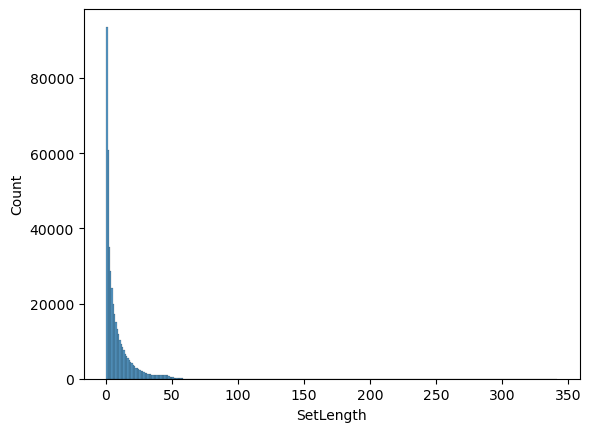

In [16]:
sns.histplot(data = tinder, x = 'SetLength', discrete = True)

We can also look at the frequency of any words that are used. Below, we see that there are 79,693 unique words that are used from all of the reviews. The five most common are 'app', 'get', 'good', 'tinder' and 'like.

In [17]:
from collections import Counter

def count_words(df):
    count = Counter()
    for text in df['Tokenized'].values:
        for word in text:
            count[word] += 1
    return count

word_freq = count_words(tinder)
print(len(word_freq))
print(word_freq.most_common(5))

79693
[('app', 144790), ('get', 71702), ('good', 52264), ('tinder', 49706), ('like', 48659)]


We now know some of the most frequent words used in these reviews but what are the most common words used for reviews depending on if the review is positive or not?

Positive Reveiw Unique Words 33015


[Text(0.5, 1.0, 'Positive Review')]

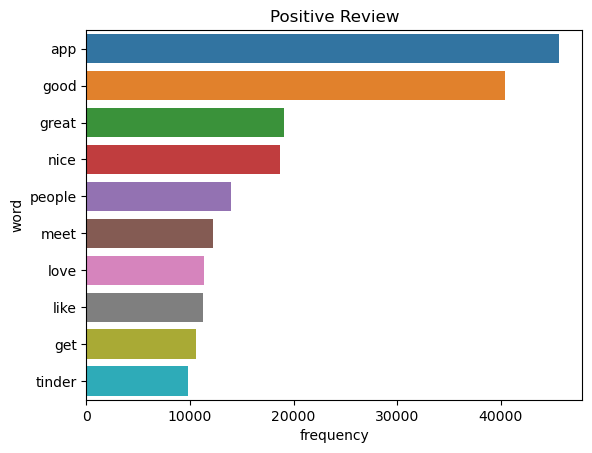

In [18]:
good_reviews = tinder[tinder['sentiment'] == 1]
bad_reviews = tinder[tinder['sentiment'] == 0]

good_freq = count_words(good_reviews)
bad_freq = count_words(bad_reviews)

print('Positive Reveiw Unique Words', len(good_freq))

most_good = good_freq.most_common(10)
most_good = pd.DataFrame(most_good, columns = ['word', 'frequency'])
sns.barplot(data = most_good, y = most_good['word'],
           x = most_good['frequency'], errorbar = None).set(title = 'Positive Review')

Negative Review Unique Words 62640


[Text(0.5, 1.0, 'Negative Review')]

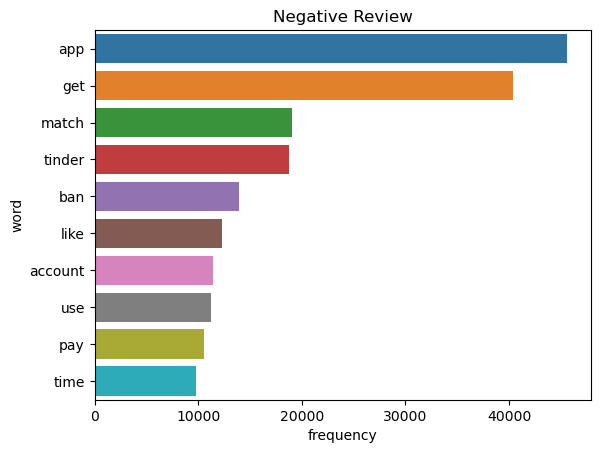

In [19]:
print('Negative Review Unique Words', len(bad_freq))

most_bad = bad_freq.most_common(10)
most_bad = pd.DataFrame(most_bad, columns = ['word', 'frequency'])
sns.barplot(data = most_bad, y = most_bad['word'],
           x = most_good['frequency'], errorbar = None).set(title = 'Negative Review')

From the charts above, the vocabulary from negative reviews is almost double of that of positive reviews. Both positive and negative reviews have 'app' as the most common word used. Positive reviews look to have some obvious vocabulary such as good, great, and love. These three terms tend to have a more positive sentiment in the context they are used in. In negative reviews, it looks like there are a lot of reviews about being banned or other problems with the user's account since terms like 'ban', 'account', and 'pay' are commonly seen.

## Deep Learning Model Architecture

Now we begin to transform the list of words into numbers so the deep learning models can use that data. First, we shuffle the data around and split the data into three different datasets. The three datasets are the training dataset, the validation dataset, and the test dataset. The validation and test datasets will each have 50,000 data points while the training dataset will have the 334,207 remaining data points.

In [20]:
#shuffle before splitting data
tinder_shuffle = tinder.sample(frac = 1)
tinder_shuffle = tinder_shuffle.reset_index(drop =  True)

In [21]:
X_test = list(tinder_shuffle['Tokenized'].iloc[0:50000])
X_val = list(tinder_shuffle['Tokenized'].iloc[50000:100000])
X_train = list(tinder_shuffle['Tokenized'].iloc[100000:])

y_test = tinder_shuffle['sentiment'].iloc[0:50000].to_numpy()
y_val = tinder_shuffle['sentiment'].iloc[50000:100000].to_numpy()
y_train = tinder_shuffle['sentiment'].iloc[100000:].to_numpy()

In [22]:
print('Train Dataset',len(X_train))
print('Validation Dataset', len(X_val))
print('Test Dataset',len(X_test))

Train Dataset 334207
Validation Dataset 50000
Test Dataset 50000


Next, we will use Tokenizer from the keras library to create a dictionary of all the unique words. Each unique word will be assigned a number. Below, you can see that 'app' is assigned to 1, 'get' is assigned to 2 and so on. Two tokenizers are created since we will be testing how the models fare with using all the unique vocabulary versus using a limited vocabulary. The first tokenizer will include all unique words while the second one will only include the top 10,000 most used words.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer1 = Tokenizer(num_words = len(word_freq))
tokenizer2 = Tokenizer(num_words = 10000, oov_token = 'oov')

In [24]:
tokenizer1.fit_on_texts(X_train)
tokenizer2.fit_on_texts(X_train)

In [25]:
import itertools
dict(itertools.islice(tokenizer1.word_index.items(), 10))

{'app': 1,
 'get': 2,
 'good': 3,
 'tinder': 4,
 'like': 5,
 'match': 6,
 'people': 7,
 'ban': 8,
 'use': 9,
 'account': 10}

The tokenizer turns the text of the reviews into numbers.

In [26]:
X_train_seq = tokenizer1.texts_to_sequences(X_train)
X_val_seq = tokenizer1.texts_to_sequences(X_val)
X_test_seq = tokenizer1.texts_to_sequences(X_test)

X_train_seq2 = tokenizer2.texts_to_sequences(X_train)
X_val_seq2 = tokenizer2.texts_to_sequences(X_val)
X_test_seq2 = tokenizer2.texts_to_sequences(X_test)

In [27]:
print(X_train[987])
print(X_train_seq[987])

['simple', 'use']
[366, 9]


When processing sequence data, it is very common for individual samples to have different lengths. However, the input data for a deep learning model must be a single tensor. Most reviews are 4 fewer words while the longest one is 341 words. We will have two different lengths of padded reviews. We will have a length of 25 for the dataset with a complete vocabulary and a length of 15 for the tokenized text with only the top 10,000 most used words. If the reveiw is shorter than the given length, zeros will be added to the end. If it is longer, then it will be truncated. Another example is shown below before padding and after padding.

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_seq, maxlen = 25, padding = "post", truncating = "post")
X_val_padded = pad_sequences(X_val_seq, maxlen = 25, padding = "post", truncating = "post")
X_test_padded = pad_sequences(X_test_seq, maxlen = 25, padding = "post", truncating = "post")
print(X_train_padded.shape, X_val_padded.shape, X_test_padded.shape)

(334207, 25) (50000, 25) (50000, 25)


In [29]:
X_train_padded2 = pad_sequences(X_train_seq2, maxlen = 15, padding = "post", truncating = "post")
X_val_padded2 = pad_sequences(X_val_seq2, maxlen = 15, padding = "post", truncating = "post")
X_test_padded2 = pad_sequences(X_test_seq2, maxlen = 15, padding = "post", truncating = "post")
print(X_train_padded2.shape, X_val_padded2.shape, X_test_padded2.shape)

(334207, 15) (50000, 15) (50000, 15)


In [30]:
#unpadded vs padded 
print('unpadded', X_train_seq[987])
print('padded', X_train_padded[987])

unpadded [366, 9]
padded [366   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


### LSTM Models

The first model we will be creating will be the LSTM model. LSTM is a Long-Short Term Memory model which is a type of Recurrent Neural Network. LSTM is made up of three gates which are the input gate, forget gate and output gate. A LSTM model works well with the the data we have since the neural network has "memory" can past data can influence future decision making. In this case, words in the beginning of the review influence words from later on in the review. If I were to make a prediction, the LSTM model will work better with the dataset with the complete vocabulary dictionary and longer reviews since LSTM models tend to work better with more complex datasets.

For this LSTM model, I started with an Embedding layer. The Embedding layer is to help the neural network understand the inputs given. The length of tokenizer.word_index is all the possible words that can appear while the input length is the length of each review with padding. A bidirectional LSTM layer is added afterwards. Since order matters in a review, a bidirectional LSTM layer works better than just an LSTM layer. Finally, there is a Dense layer with 64 or 128 units and another Dense layer with a sigmoid activation to determine if the review is positive or not.

The keras tuner class is used to tune hyperparameters such as the number of filters for the Embedding and LSTM layers.

In [52]:
from keras import layers
import keras_tuner

def build_lstm(hp):
                                      
    lstm_model = keras.models.Sequential()
    lstm_model.add(layers.Embedding(len(tokenizer1.word_index),hp.Choice('filter1',[16,32]),input_length = 25))
    lstm_model.add(layers.Bidirectional(layers.LSTM(hp.Choice('filter2',[16,32]))))
    lstm_model.add(layers.Dropout(hp.Float('drop1', 0.1,0.2, step = 0.1)))
    lstm_model.add(layers.BatchNormalization())
    lstm_model.add(layers.Dense(hp.Choice('dense1',[64,128]), activation = 'relu'))
    lstm_model.add(layers.BatchNormalization())
    lstm_model.add(layers.Dense(1, activation = "sigmoid"))

    opt = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr',[0.001,0.0001]))

    lstm_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

    return lstm_model

In [55]:
from keras_tuner.tuners import RandomSearch
tuner_lstm = RandomSearch(
    build_lstm,
    objective = 'val_accuracy',
    max_trials = 32,
    executions_per_trial = 1,
    overwrite = True,
    directory = '../DatingApps/',
    project_name = 'tuner'
)

All the different permutations of the hyperparameters are given below. All models will follow these hyperparameter permutations.

In [50]:
tuner_lstm.search_space_summary()

Search space summary
Default search space size: 5
filter1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
filter2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
drop1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}
dense1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
lr (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [56]:
epoch = 5
tuner_lstm.search(X_train_padded, y_train, epochs = epoch, validation_data = (X_val_padded, y_val), batch_size = 256)

Trial 30 Complete [00h 01m 41s]
val_accuracy: 0.8898199796676636

Best val_accuracy So Far: 0.8902999758720398
Total elapsed time: 00h 50m 18s
INFO:tensorflow:Oracle triggered exit


The second LSTM model is using the dataset with a 10,000 maximum vocabulary and each review tensor has a length a 15.

In [57]:
def build_lstm2(hp):
                                      
    lstm_model = keras.models.Sequential()
    lstm_model.add(layers.Embedding(len(tokenizer2.word_index),hp.Choice('filter1',[16,32]),input_length = 15))
    lstm_model.add(layers.Bidirectional(layers.LSTM(hp.Choice('filter2',[16,32]))))
    lstm_model.add(layers.Dropout(hp.Float('drop1', 0.1,0.2, step = 0.1)))
    lstm_model.add(layers.BatchNormalization())
    lstm_model.add(layers.Dense(hp.Choice('dense1',[64,128]), activation = 'relu'))
    lstm_model.add(layers.Dense(1, activation = "sigmoid"))

    opt = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr',[0.001,0.0001]))

    lstm_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

    return lstm_model

In [58]:
tuner_lstm2 = RandomSearch(
    build_lstm2,
    objective = 'val_accuracy',
    max_trials = 32,
    executions_per_trial = 1,
    overwrite = True,
    directory = '../DatingApps/',
    project_name = 'tuner2'
)

In [59]:
tuner_lstm2.search(X_train_padded2, y_train, epochs = 5, validation_data = (X_val_padded2, y_val), batch_size = 256)

Trial 30 Complete [00h 01m 24s]
val_accuracy: 0.8896200060844421

Best val_accuracy So Far: 0.8903800249099731
Total elapsed time: 00h 42m 40s
INFO:tensorflow:Oracle triggered exit


The best validation accuracy for the first model is 0.8903 and the best validation accuracy for the second model is 0.89038. The scores are very close but the second model is ever slightly better. This is quite surprising since I predicted the first model with the more complex dataset will do better. The second model also has a shorter input and a shorter word index, it is also more than 7 minutes faster running all the hyperparameter possibilities. 
Listed below are the best two combinations of hyperparameters for the two models with different datasets.

In [60]:
best_lstm = tuner_lstm.get_best_hyperparameters(num_trials = 1)[0]
print(best_lstm.values)
best_lstm2 = tuner_lstm2.get_best_hyperparameters(num_trials = 1)[0]
print(best_lstm2.values)

{'filter1': 32, 'filter2': 16, 'drop1': 0.1, 'dense1': 64, 'lr': 0.0001}
{'filter1': 16, 'filter2': 32, 'drop1': 0.1, 'dense1': 64, 'lr': 0.001}


Shown is a summary of the best LSTM model from both datasets. The best model used the simplified dataset of 10,000 unique words with a maximum length of 15 words. The best parameters are:
- 16 units for  the Embedding layer
- 32 units for the LSTM layer, 64 total since the LSTM layer is bidirectional
- 0.1 dropout
- 64 units for the Dense layer
- learning rate of 0.001

A summary of that model is below:

In [74]:
best_lstm_model = tuner_lstm2.hypermodel.build(best_lstm2)
best_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 15, 16)            1075472   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                12544     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,092,497
Trainable params: 1,092,369
Non-trainable params: 128
__________________________________________

In the accuracy graph, we see that after the third epoch, the validation accuracy did not really improve. In the loss graph, the validation loss was the least at the third epoch. This shows a bit of overfitting but not a drastic example of overfitting.

In [75]:
history_lstm = best_lstm_model.fit(X_train_padded2, y_train, epochs = 5, 
                                   validation_data = (X_val_padded2, y_val), batch_size = 256, verbose = 0)

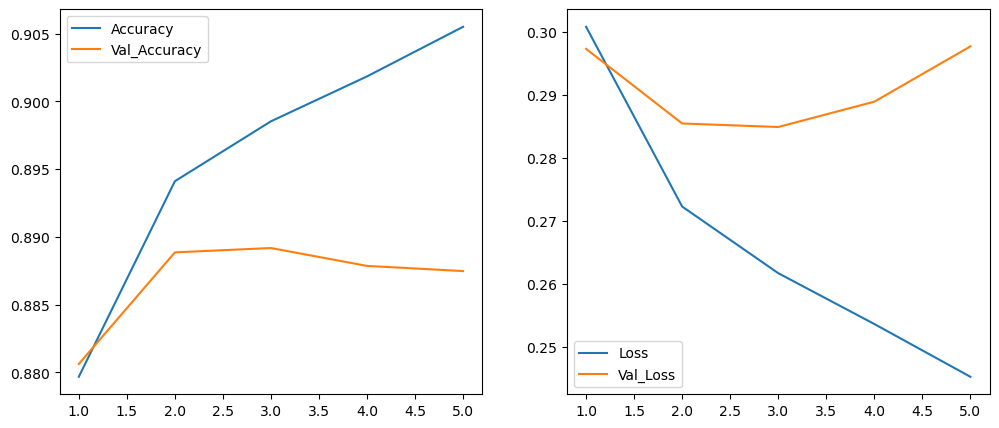

In [76]:
epoch = 5
epoch_lst = list(range(1, epoch + 1))
accuracy = pd.DataFrame(list(zip(epoch_lst, history_lstm.history['accuracy'],
                        history_lstm.history['val_accuracy'])),
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])
loss = pd.DataFrame(list(zip(epoch_lst, history_lstm.history['loss'],
                        history_lstm.history['val_loss'])),
                        columns = ['Epoch','Loss', 'Val_Loss'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy['Epoch'],accuracy['Accuracy'])
ax1.plot(accuracy['Epoch'],accuracy['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss['Epoch'], loss['Loss'])
ax2.plot(loss['Epoch'], loss['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])


Now that we have our LSTM models trained, we can use the best one to predict the sentiment of the test dataset. Out of 50,000 reviews in the test dataset, 25,216 of the negative reviews were predicted correctly. There were 19,196 positive reviews that were predicted correctly. Of the improperly predicted reviews, 2,896 negative reviews were improperly predicted as positive reviews and 2,692 positive reviews were improperly predicted as negative reviews. 

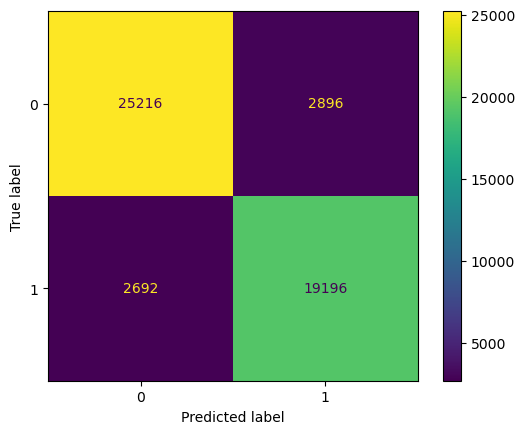

In [82]:
y_pred_lstm = best_lstm_model.predict(X_test_padded2)
y_pred_lstm = np.round(y_pred_lstm,0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm_lstm)
disp1.plot()

### GRU Model

The second type of model we will use is the GRU model. The GRU model is similar to the LSTM model but has one less gate. It contains an update gate and a reset gate. The update gate acts similarly to the forget and imput gate of an LSTM which decides which imformation to keep and forget. The reset gate decides how much information to forget. For the GRU models, I predict that the simpler dataset with a 10,000 word voacabulary and a 15 length review would perform better due to less overfitting.

Like the LSTM model, there is an Embedding layer to help the neural network understand the inputs given since the input is the same as the prior model. Next there is a bidirectional GRU layer. The GRU layer is followed by two Dense layers. The first Dense layer has either 64 or 128 units. The second layer has a sigmoid activation to determine either a positive or negative review. A bidirectional GRU layer works well the same reason as why a bidirectional LSTM model worked well above.

In [83]:
def build_gru(hp):
    
    gru_model = keras.models.Sequential()
    gru_model.add(layers.Embedding(len(tokenizer1.word_index),hp.Choice('filter1',[16,32]),input_length = 25))
    gru_model.add(layers.Bidirectional(layers.GRU(hp.Choice('filter2',[16,32]))))
    gru_model.add(layers.Dropout(hp.Float('drop1', 0.1,0.2, step = 0.1)))
    gru_model.add(layers.BatchNormalization())
    gru_model.add(layers.Dense(hp.Choice('dense1',[64,128]), activation = 'relu'))
    gru_model.add(layers.Dense(1, activation = "sigmoid"))

    opt = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr',[0.001,0.0001]))

    gru_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

    return gru_model

In [84]:
from keras_tuner.tuners import RandomSearch
tuner_gru = RandomSearch(
    build_gru,
    objective = 'val_accuracy',
    max_trials = 32,
    executions_per_trial = 1,
    overwrite = True,
    directory = '../DatingApps/',
    project_name = 'tuner_gru1'
)

In [85]:
tuner_gru.search(X_train_padded, y_train, epochs = 5, validation_data = (X_val_padded, y_val), batch_size = 256)

Trial 28 Complete [00h 01m 24s]
val_accuracy: 0.8891599774360657

Best val_accuracy So Far: 0.8906800150871277
Total elapsed time: 00h 38m 07s
INFO:tensorflow:Oracle triggered exit


In [86]:
def build_gru2(hp):
    
    gru_model = keras.models.Sequential()
    gru_model.add(layers.Embedding(len(tokenizer2.word_index),hp.Choice('filter1',[16,32]),input_length = 15))
    gru_model.add(layers.Bidirectional(layers.GRU(hp.Choice('filter2',[16,32]))))
    gru_model.add(layers.Dropout(hp.Float('drop1', 0.1,0.2, step = 0.1)))
    gru_model.add(layers.BatchNormalization())
    gru_model.add(layers.Dense(hp.Choice('dense1',[64,128]), activation = 'relu'))
    gru_model.add(layers.Dense(1, activation = "sigmoid"))

    opt = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr',[0.001,0.0001]))

    gru_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

    return gru_model

In [87]:
from keras_tuner.tuners import RandomSearch
tuner_gru2 = RandomSearch(
    build_gru2,
    objective = 'val_accuracy',
    max_trials = 32,
    executions_per_trial = 1,
    overwrite = True,
    directory = '../DatingApps/',
    project_name = 'tuner_gru2'
)
tuner_gru2.search(X_train_padded2, y_train, epochs = 5, validation_data = (X_val_padded2, y_val), batch_size = 256)

Trial 29 Complete [00h 01m 15s]
val_accuracy: 0.8893399834632874

Best val_accuracy So Far: 0.8899199962615967
Total elapsed time: 00h 36m 01s
INFO:tensorflow:Oracle triggered exit


The best validation accuracy for the first model is 0.8907 and the best validation accuracy for the second model is 0.8899. The scores are very close but this time the first model is ever slightly better. Surprisingly, the larger dataset worked better in this case.  Listed below are the best two combinations of hyperparameters for the two models with different datasets.

In [88]:
best_gru = tuner_gru.get_best_hyperparameters(num_trials = 1)[0]
print(best_gru.values)
best_gru2 = tuner_gru2.get_best_hyperparameters(num_trials = 1)[0]
print(best_gru2.values)

{'filter1': 32, 'filter2': 32, 'drop1': 0.2, 'dense1': 64, 'lr': 0.001}
{'filter1': 32, 'filter2': 16, 'drop1': 0.2, 'dense1': 128, 'lr': 0.001}


Shown is a summary of the best GRU model from both datasets. The best model used the complete dataset of all possible unique words with a maximum length of 25 words. The best parameters are:

- 32 units for the Embedding layer
- 32 units for the LSTM layer, 64 total since the LSTM layer is bidirectional
- 0.2 dropout
- 64 units for the Dense layer
- learning rate of 0.001
- A summary of that model is below:

The summary is shown below:

In [212]:
best_gru_model = tuner_gru.hypermodel.build(best_gru)
best_gru_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 25, 32)            2150912   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 2,168,065
Trainable params: 2,167,937
Non-trainable params: 128
_________________________________________

In the accuracy chart, validation accuracy started high and mostly trended downwards as the epochs increased. For the loss chart, the validation loss was higher the whole time. The overfitting can be attributed to using larger vocabulary dataset and longer review length. Although I was incorrect for which dataset would fare better for classification validation, I was correct in the fact the the model with the larger dataset has a ton of overfitting issues.

In [214]:
history_gru = best_gru_model.fit(X_train_padded, y_train, epochs = 5, 
                                 validation_data = (X_val_padded, y_val), batch_size = 256, verbose = 0)

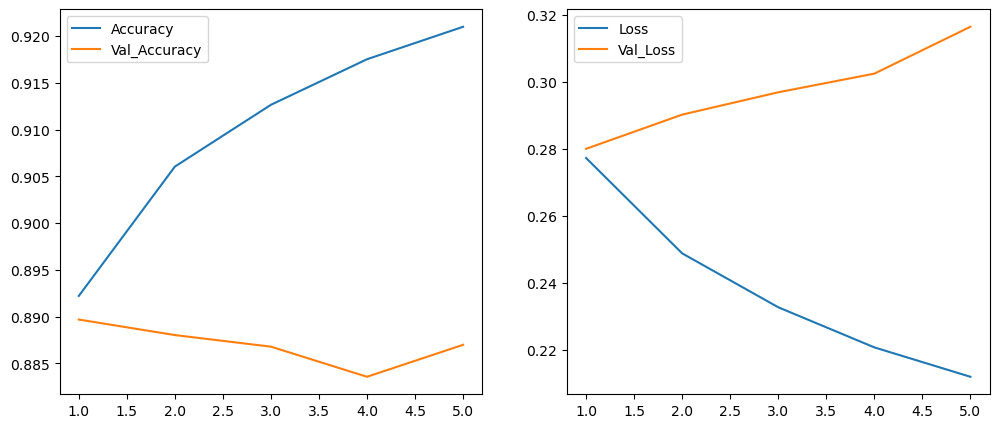

In [215]:
epoch = 5
epoch_lst = list(range(1, epoch + 1))
accuracy = pd.DataFrame(list(zip(epoch_lst, history_gru.history['accuracy'],
                        history_gru.history['val_accuracy'])),
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])
loss = pd.DataFrame(list(zip(epoch_lst, history_gru.history['loss'],
                        history_gru.history['val_loss'])),
                        columns = ['Epoch','Loss', 'Val_Loss'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy['Epoch'],accuracy['Accuracy'])
ax1.plot(accuracy['Epoch'],accuracy['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss['Epoch'], loss['Loss'])
ax2.plot(loss['Epoch'], loss['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])

Even though the charts above look to have high amounts of overfitting, the prediction results still come out quite favorable. Out of 50,000 reviews in the test dataset, 25,394 of the negative reviews were predicted correctly. There were 18,916 positive reviews that were predicted correctly. Of the improperly predicted reviews, 2,718 negative reviews were improperly predicted as positive reviews and 2,972 positive reviews were improperly predicted as negative reviews.

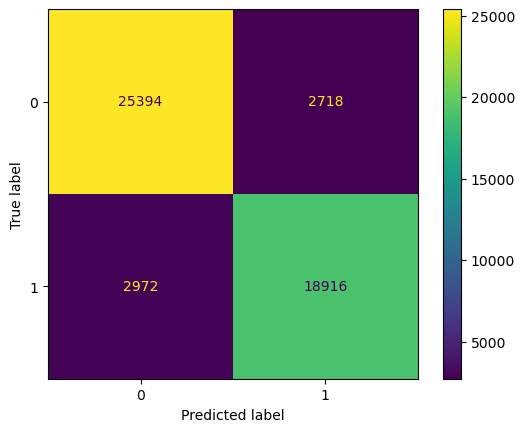

In [216]:
y_pred_gru = best_gru_model.predict(X_test_padded)
y_pred_gru = np.round(y_pred_gru,0)
cm_gru = confusion_matrix(y_test, y_pred_gru)
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm_gru)
disp2.plot()

## Conclusion

In this notebook, we have gone through classifying reviews sentiment for Tinder. We have had success in predicting if a review of an app is positive or negative. Being able to predict a review sentiment can help app creators understand what users like or dislike about the app. One thing that went well for the sentiment classification was the accuracy. For both the validation dataset and the prediction dataset, we were able to predict almost 90% of the reviews correctly. Of the four different models we trained, I would say the LSTM model with the full vocabulary with the maximum length of 25 words per review(first model) is the best. Although the first GRU model had an ever so slightly higher validation accuracy, the extreme overfitting would push me away from using it. If more review information was introduced in the future, the model would have a harder time adjusting to new training, validation, or test data. Continuing on, one challenge we had was getting the model to not overfit the training data. Natural language processing tends to overfit easily since there are so many possibility of unique words making the number of possible permutations of those words even greater. As seen in the results, the simpler dataset with only 10,000 possible unique words and a max length of 15 words per review fared better when it came to overfitting.
